![image](resources/qcqh-lab-header.png)

## Lab 8: Quantum Chemistry

<img src="resources/quantum-chemistry.png">

In this lab, you will run through an example of a quantum chemistry problem. You will be exploring the simulation of the molecule LiH in Qiskit. You will need to follow the video associated with this lab.

### Installing necessary packages

Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [1]:
!pip install -U -r resources/requirements.txt

from IPython.display import clear_output
clear_output()

## Simulating LiH

In [2]:
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

molecular_coordinates = 'Li 0 0 0; H 1.6 0 0'

distance_unit = UnitsType.ANGSTROM

basis = 'sto3g'

driver = PySCFDriver(molecular_coordinates, unit=distance_unit)

molecule = driver.run()

h1 = molecule.one_body_integrals

print(h1)

[[-4.72739313  0.10549968  0.16696141  0.          0.         -0.0346772
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10549968 -1.49264622  0.03289282  0.          0.         -0.05270788
   0.          0.          0.          0.          0.          0.        ]
 [ 0.16696141  0.03289282 -1.12554474  0.          0.          0.03044557
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.13579985  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.13579985  0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.0346772  -0.05270788  0.03044557  0.          0.         -0.95096659
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -4.72739313  0.10549968  0.16696141  0.          0.    

In [3]:
h2 = molecule.two_body_integrals
print(h2)

[[[[-8.29283343e-01  5.58549882e-02  6.92873148e-02 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 5.58549882e-02 -6.66878909e-03 -5.60788725e-03 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 6.92873148e-02 -5.60788725e-03 -1.08311226e-02 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  [[ 5.58549882e-02 -6.66878909e-03 -5.60788725e-03 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [-1.83350520e-01 -3.10515039e-03  7.93404250e-03 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [-6.72563783e-03  1.67469536e-03 -8.81386236e-05 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   ...
   

In [4]:
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

print(nuclear_repulsion_energy)

0.992207270475


# 1. Creating a Fermionic Operator 

In [5]:
from qiskit.chemistry import FermionicOperator

ferOp = FermionicOperator(h1=h1, h2=h2)

num_spin_orbitals = molecule.num_orbitals * 2
num_particles = molecule.num_alpha + molecule.num_beta

freeze_list = [0,6] 

remove_list = [3,8]


In [6]:
ferOp_f, energy_shift = ferOp.fermion_mode_freezing(freeze_list)

num_spin_orbitals -= len(freeze_list)
num_particles -= len(freeze_list)

print(ferOp_f.h1)

[[-0.77258172  0.0485796   0.          0.         -0.12679498  0.
   0.          0.          0.          0.        ]
 [ 0.0485796  -0.35593954  0.          0.          0.06813315  0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.35297897  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.35297897  0.          0.
   0.          0.          0.          0.        ]
 [-0.12679498  0.06813315  0.          0.         -0.236054    0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.77258172
   0.0485796   0.          0.         -0.12679498]
 [ 0.          0.          0.          0.          0.          0.0485796
  -0.35593954  0.          0.          0.06813315]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.35297897  0.          0.        ]
 [ 0.          0.          0.          0.        

In [7]:
ferOp_fr = ferOp_f.fermion_mode_elimination(remove_list)

num_spin_orbitals -= len(remove_list)

print(ferOp_fr.h1)

[[-0.77258172  0.0485796   0.         -0.12679498  0.          0.
   0.          0.        ]
 [ 0.0485796  -0.35593954  0.          0.06813315  0.          0.
   0.          0.        ]
 [ 0.          0.         -0.35297897  0.          0.          0.
   0.          0.        ]
 [-0.12679498  0.06813315  0.         -0.236054    0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.         -0.77258172  0.0485796
   0.         -0.12679498]
 [ 0.          0.          0.          0.          0.0485796  -0.35593954
   0.          0.06813315]
 [ 0.          0.          0.          0.          0.          0.
  -0.35297897  0.        ]
 [ 0.          0.          0.          0.         -0.12679498  0.06813315
   0.         -0.236054  ]]


# 2. Creating a Qubit Operator 

In [8]:
map_type = 'parity'

qubitOp = ferOp_fr.mapping(map_type=map_type)

print(qubitOp)
print(qubitOp.print_details())

Representation: paulis, qubits: 8, size: 193
IIIIIIII	(0.2956785198716415+0j)
IIIIIIIZ	(-0.1692465869297233+0j)
IIIIIIZX	(0.0016203457124031322+0j)
IIIIIIIX	(-0.0016203457124031322+0j)
IIIIZXXX	(0.009960051780400882+0j)
IIIIIYXY	(0.009960051780400882+0j)
IIIIIIZZ	(-0.25982209985093985+0j)
IIIIZXXZ	(-0.019558761919290422+0j)
IIIIIYYI	(-0.019558761919290422+0j)
IIIIIZZI	(-0.29078711634060106+0j)
IIIIZZII	(-0.43459982901407335+0j)
IIIZZIII	(-0.16924658692972322+0j)
IIZXZIII	(0.00162034571240313+0j)
IIIXIIII	(-0.00162034571240313+0j)
ZXXXZIII	(0.009960051780400866+0j)
IYXYIIII	(0.009960051780400866+0j)
IIZZIIII	(-0.2598220998509399+0j)
ZXXZIIII	(-0.01955876191929042+0j)
IYYIIIII	(-0.01955876191929042+0j)
IZZIIIII	(-0.29078711634060106+0j)
ZZIIIIII	(-0.43459982901407335+0j)
IIIIIIZI	(0.0526365152855009+0j)
IIIIZXXI	(-0.0041915663201469175+0j)
IIIIIYYZ	(-0.0041915663201469175+0j)
IIIIIZZZ	(0.06168720475907178+0j)
IIIIZZIZ	(0.08247949378222305+0j)
IIIIZXYY	(0.0054561562893191175+0j)
IIIIIYYX	

In [9]:
from qiskit.aqua.operators import Z2Symmetries

pauli_symm = Z2Symmetries.find_Z2_symmetries(qubitOp)
print(pauli_symm)

Z2 symmetries:
Symmetries:
IIIIZIII
IZZIIZZI
ZIIIIIII
Single-Qubit Pauli X:
IIIIXIII
IIIIIIXI
XIIIIIII
Cliffords:
IIIIZIII	(0.7071067811865475+0j)
IIIIXIII	(0.7071067811865475+0j)

IZZIIZZI	(0.7071067811865475+0j)
IIIIIIXI	(0.7071067811865475+0j)

ZIIIIIII	(0.7071067811865475+0j)
XIIIIIII	(0.7071067811865475+0j)

Qubit index:
[3, 1, 7]
Tapering values:
  - Possible values: [1, 1, 1], [1, 1, -1], [1, -1, 1], [1, -1, -1], [-1, 1, 1], [-1, 1, -1], [-1, -1, 1], [-1, -1, -1]


In [10]:
qubitOp_t = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)

print(num_particles)

print(qubitOp_t)
print(qubitOp_t.print_details())

2
Representation: paulis, qubits: 6, size: 175
IIIIII	(0.2956785198716414+0j)
IIIIIZ	(-0.16924658692972325+0j)
IIIIZX	(0.0016203457124031315+0j)
IIIIIX	(-0.0016203457124031315+0j)
IIIXXX	(-0.009960051780400879+0j)
IIIYXY	(0.009960051780400879+0j)
IIIIZZ	(-0.25982209985093974+0j)
IIIXXZ	(0.019558761919290416+0j)
IIIYYI	(-0.019558761919290416+0j)
IIIZZI	(-0.29078711634060095+0j)
IIIZII	(0.43459982901407324+0j)
IIZIII	(0.16924658692972316+0j)
IZXIII	(-0.0016203457124031296+0j)
IIXIII	(-0.0016203457124031296+0j)
XXXIII	(-0.009960051780400863+0j)
YXYIII	(0.009960051780400863+0j)
IZZIII	(-0.2598220998509398+0j)
XXZIII	(-0.019558761919290412+0j)
YYIIII	(-0.019558761919290412+0j)
ZZIIII	(-0.29078711634060095+0j)
ZIIIII	(-0.43459982901407324+0j)
IIIIZI	(-0.009465025133421803+0j)
IIIXXI	(0.00020129830787017286+0j)
IIIYYZ	(-0.00020129830787017286+0j)
IIIZZZ	(0.007940339014440613+0j)
IIIZIZ	(-0.022300831540825884+0j)
IIIXYY	(-0.004635596534255202+0j)
IIIYYX	(-0.004635596534255202+0j)
IIIZIX	(-0.00

In [11]:
from qiskit.aqua.algorithms import NumPyEigensolver

ee = NumPyEigensolver(qubitOp_t)

result = ee.run()
ref = result['eigenvalues']

print(ref + nuclear_repulsion_energy + energy_shift)

[-7.88159204+2.08248394e-17j]


# Creating a Variational Ansatz 

two_qubit_reduction only works with parity qubit mapping but you have jordan_wigner. We switch two_qubit_reduction to False.


[False  True False  True]


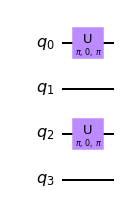

In [12]:
from qiskit.chemistry.components.initial_states import HartreeFock

init_state = HartreeFock(num_orbitals=4, num_particles=2, qubit_mapping='jordan_wigner')

print(init_state.bitstr)

HF_circuit = init_state.construct_circuit('circuit')
HF_circuit.decompose().draw(output='mpl')

In [13]:
from qiskit.chemistry.components.variational_forms import UCCSD

UCCSD_var_form = UCCSD(num_orbitals=4, num_particles=2, qubit_mapping='jordan_wigner',
                      excitation_type='s', method_singles='beta',
                      initial_state=init_state, two_qubit_reduction=False, reps=2)

print(UCCSD_var_form.single_excitations)
print(UCCSD_var_form.num_parameters)

[[2, 3]]
2


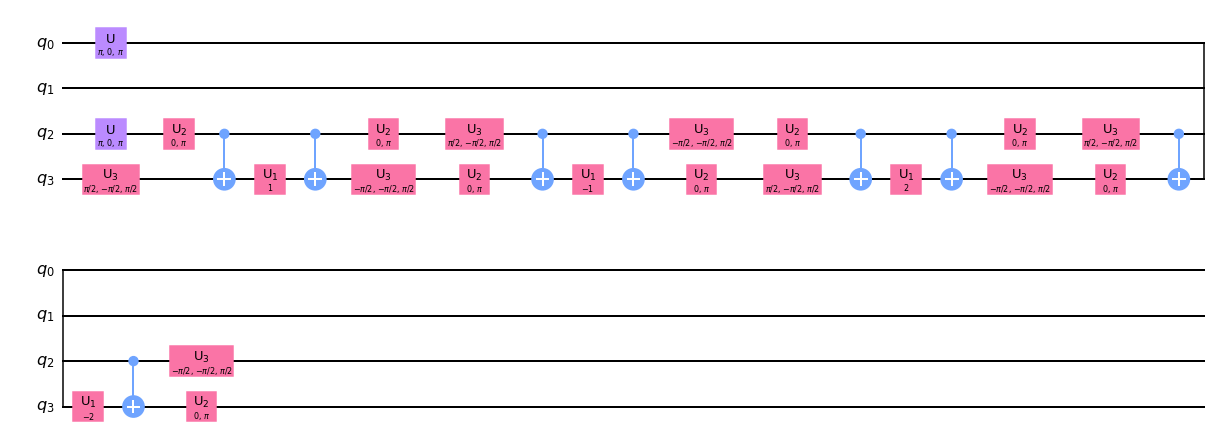

In [14]:
var_circuit = UCCSD_var_form.construct_circuit([1,2])

var_circuit.decompose().draw(output='mpl')

# Homework - The last symmetry standing 

In [ ]:
pauli_symm = Z2Symmetries.find_Z2_symmetries(qubitOp_t)
print(pauli_symm)